# Copernicus Climate Data Store (CDS) access using xcube

This notebook walks provides a walk-through demonstrating how to use xcube and the xcube Climate Data Store (CDS) plugin to read and explore temperature data from the CDS.

Before using this notebook, ensure that you have set up xcube, the CDS plugin, and Jupyter Lab as described in the [Ex0-CDS-store-Setup](./Ex0-CDS-store-setup.ipynb) notebook.

First, we import some necessary libraries.

In [1]:
# xcube and xcube_cds imports
import xcube
from xcube_cds.store import CDSDataStore

# Various utilities
import shapely.geometry
import IPython.display

Configure matplotlib to display graphs inline directly in the notebook.

In [2]:
%matplotlib inline

Create a CDS data store object. The optional `normalize_names` parameter specifies that variable names in returned data cubes will be converted to legal Python identifiers, if required.

In [3]:
cds_store = CDSDataStore(normalize_names=True)

Find out which datasets are available from this store. We get a list of tuples; the first member of each tuple is the data ID, and the second member is a short description of the dataset. We pick ‘ERA5 monthly averaged data on single levels – Monthly averaged reanalysis’.

In [4]:
data_ids = list(cds_store.get_data_ids())
data_ids

[('reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis_by_hour_of_day',
  'ERA5 monthly averaged data on single levels from 1979 to present – Monthly averaged reanalysis by hour of day'),
 ('reanalysis-era5-land', 'ERA5-Land hourly data from 1981 to present'),
 ('reanalysis-era5-single-levels-monthly-means:monthly_averaged_ensemble_members',
  'ERA5 monthly averaged data on single levels from 1979 to present – Monthly averaged ensemble members'),
 ('reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis',
  'ERA5 monthly averaged data on single levels from 1979 to present – Monthly averaged reanalysis'),
 ('reanalysis-era5-single-levels:ensemble_mean',
  'ERA5 hourly data on single levels from 1979 to present – Ensemble mean'),
 ('reanalysis-era5-single-levels-monthly-means:monthly_averaged_ensemble_members_by_hour_of_day',
  'ERA5 monthly averaged data on single levels from 1979 to present – Monthly averaged ensemble members by hour of day'),
 ('re

In [5]:
data_id = 'reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis'

Let's see what parameters we can specify when opening the dataset. Four are listed as required parameters: `time_range`, `spatial_res`, `bbox`, and `variable_names`. The enumeration in `properties → variable_names → items` lists 260 variables we can request. We can request any number of variables, but for this example we will just look at `2m_temperature`.

In [6]:
cds_store.get_open_data_params_schema(data_id)

In [7]:
variable_names = ['2m_temperature']

Define the bounding box for the area of interest. For this example, we will be using the mid-latitudes of Europe.

In [8]:
w = -10  # degree
s = 45   # degree
e = 40   # degree
n = 65   # degree

bbox = [w, s, e, n]

Plot the bounding box on a map to check that we have the correct area.

In [9]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Define the desired spatial resolution. ERA5 data are available at a maximum resolution of 0.25°, so this is what we specify.

In [10]:
spatial_res = 0.25

For the time range, we select the years 2001 to 2010. The dates are specified in ISO-8601 format.

In [11]:
time_range=['2001-01-01', '2010-12-31']

List the available opener IDs for this data store. There is only one, `dataset:netcdf:cds`, which opens a dataset constructed from a NetCDF file returned from the CDS API, so we use this one.

In [12]:
openers = cds_store.get_data_opener_ids()

openers

('dataset:netcdf:cds',)

In [13]:
opener = openers[0]

Open the data cube from the store. It may take one or two minutes for the CDS servers to process the request.

In [14]:
cube = cds_store.open_data(data_id,
                           opener,
                           variable_names=variable_names,
                           bbox=bbox,
                           spatial_res=spatial_res,
                           time_range=time_range)

2020-09-10 11:17:57,816 INFO Welcome to the CDS
2020-09-10 11:17:57,818 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2020-09-10 11:17:59,989 INFO Request is completed
2020-09-10 11:17:59,990 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data8/adaptor.mars.internal-1599726788.4804425-19659-22-c56c47d7-febe-4e17-93a5-6f5f8004abbc.nc to /tmp/tmp7g9kgemz/tmprisqtjo1/data (3.7M)
2020-09-10 11:18:02,543 INFO Download rate 1.4M/s   


Plot the differences between successive time points in the dataset. We can see that the times are monotonically increasing (all the difference values are positive), but not equally spaced, since months are not all of the same length. The lowest values correspond to February; the four-year leap year cycle can also be discerned.

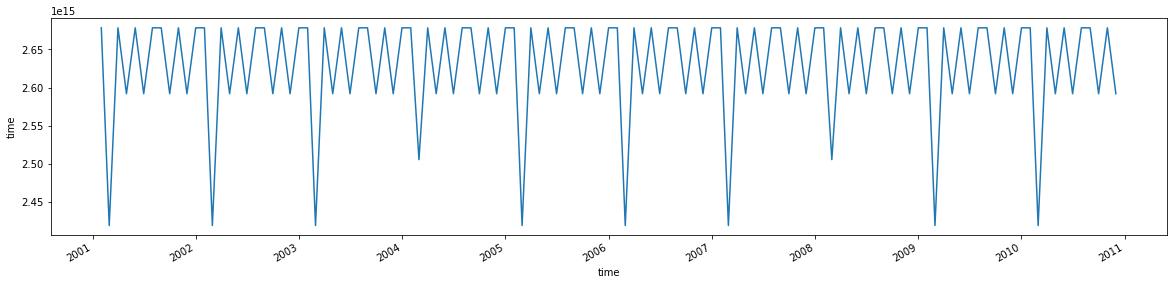

In [15]:
cube.time.diff(dim='time').plot.line(figsize=(20, 4))

We can explore these data by plotting a temperature map for selected time points. First, we select January 2001. Land areas – and mountain ranges in particular – show up on the map as colder regions.

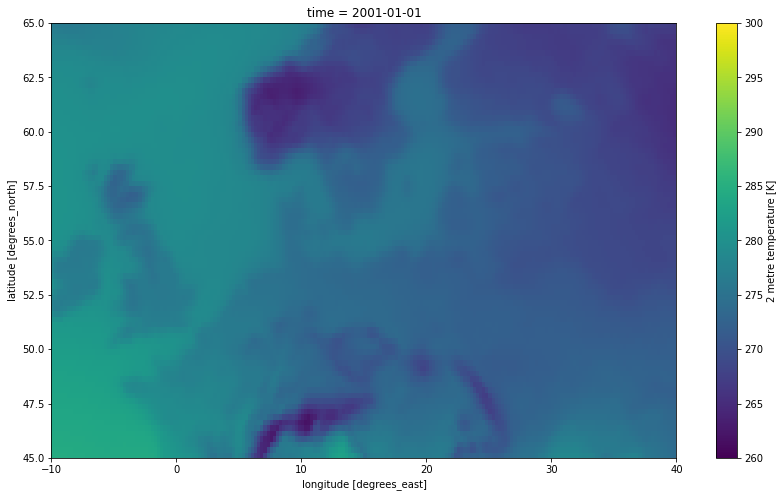

In [16]:
t2m_2001_jan = cube.t2m.sel(time='2001-01-01 00:00:00', method='nearest')
t2m_2001_jan.plot.imshow(vmin=260, vmax=300, figsize=(14, 8))

We can compare this with a plot for July of the same year using the same colour scale for temperature. As would be expected, the land/sea temperature difference is reversed, and mountainous regions are still colder than surrounding lowlands.

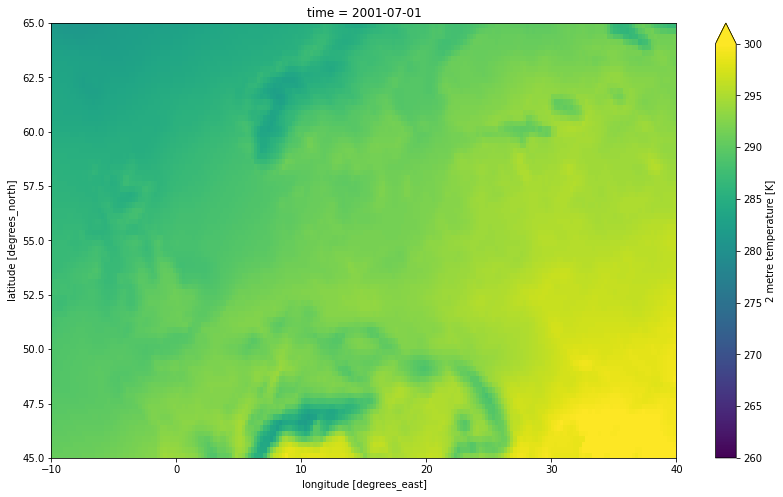

In [17]:
t2m_2001_jul = cube.t2m.sel(time='2001-07-01 00:00:00', method='nearest')
t2m_2001_jul.plot.imshow(vmin=260, vmax=300, figsize=(14, 8))

We can also subtract January from July to produce a map showing which regions have the greatest differences between summer and winter temperatures:

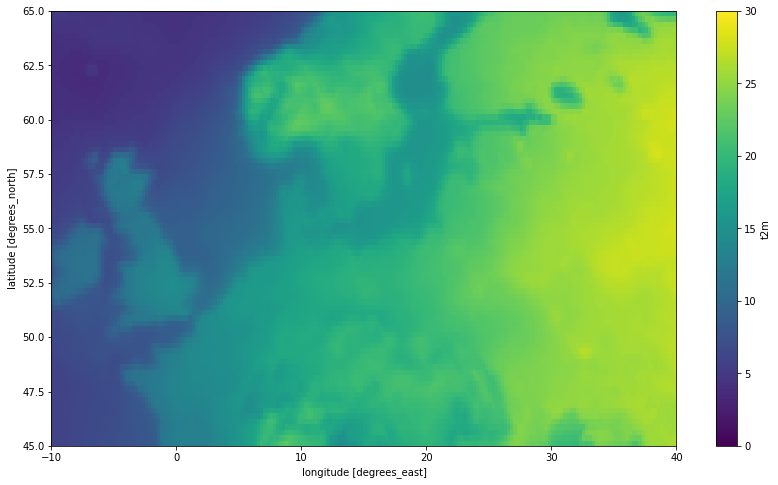

In [18]:
(t2m_2001_jul - t2m_2001_jan).plot.imshow(vmin=0, vmax=30, figsize=(14, 8))

We can make use of the 10-year time series to examine longer-term trends. First, we calculate the mean January and July temperature maps separately for the first and second halves of the dataset (i.e. for 2001-2005 and 2006-2010).

In [19]:
jan_2001_2005 = cube.t2m[0:60:12].mean(axis=0)
jan_2006_2010 = cube.t2m[60::12].mean(axis=0)
jul_2001_2005 = cube.t2m[6:60:12].mean(axis=0)
jul_2006_2010 = cube.t2m[66::12].mean(axis=0)

Now we can use these means to look at geographical variation in temperature differences between these two timespans and times of year. A plot of the difference in January temperatures shows marked rises in the Gulf of Finland, the Gulf of Bothnia, the Alps, and the Carpathians. Meanwhile, temperatures in the eastern plains have dropped.

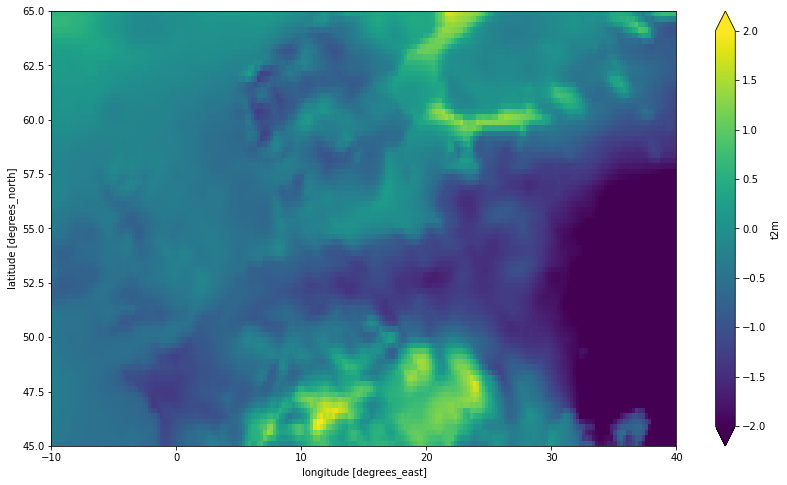

In [20]:
(jan_2006_2010 - jan_2001_2005).plot.imshow(vmin=-2, vmax=2, figsize=(14, 8))

For July temperatures, the pattern is quite different: the greatest temperature increase is seen in Germany and adjacent areas, while a cooling trend is evident in Finland, the Baltics, and western Russia.

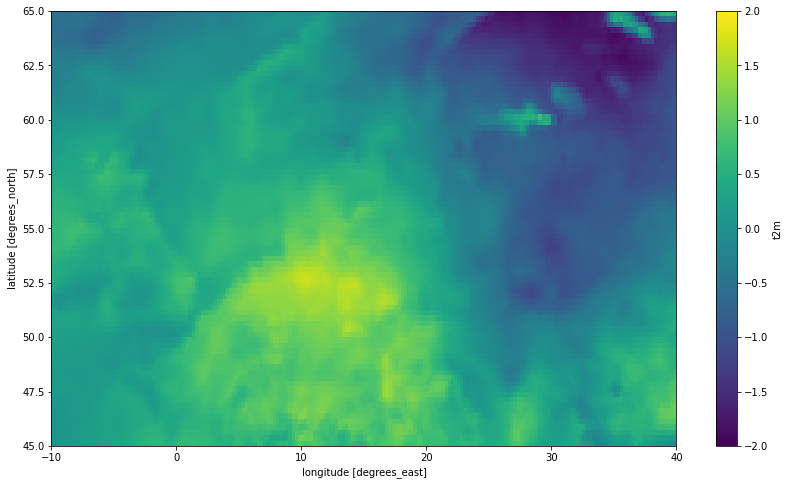

In [21]:
(jul_2006_2010 - jul_2001_2005).plot.imshow(vmin=-2, vmax=2, figsize=(14, 8))